For the tabular portion of the multimodal probabilistic M1 fusion, Gaussian Process is used, as it is particularly effective in capturing trends in time-series data, even with a small and irregular dataset. Gaussian Process is a stochastic learning method that learns the transition probability in a continuous time-scale by conditioning each discrete time-series data point with interpolated time intervals.

In [24]:
import numpy as np
import pandas as pd
from scipy import stats
import sys
from pathlib import Path
import torch
import torch.nn as nn
import gpytorch
import matplotlib.pyplot as plt
from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel, IndexKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from sklearn.metrics import mean_squared_error, r2_score

For train-test split, it is done by unique patient IDs, as each row in the CSV is not a unique entry, but a series of rows for each patient ID is. Thus, the corresponding y (outcome) only is the FVC value in the last recorded week for each patient. 

Then, numerical features are normalized to ensure their equal weightage, followed by conversion to pyTorch tensors.



In [2]:
repo_root = Path.cwd().parent
sys.path.insert(0, str(repo_root))

from preprocessing.tabular_preprocessing import train_df, val_df

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker   
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker   
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker   

   Weeks_scaled  FVC_scaled  
0     -1.510341   -0.448119  
1     -1.122587   -0.566423  
2     -1.036419   -0.745635  
3     -0.950252   -0.648415  
4     -0.864084   -0.736264  


Now that the preprocessing is complete, model is built with separate kernels for the time series, and each categorical feature.

In [13]:
X_time_train = torch.tensor(train_df[["Weeks_scaled"]].values, dtype=torch.float32)
X_age_train = torch.tensor(train_df[["Age"]].values, dtype=torch.float32)

sex_map = {k:i for i,k in enumerate(train_df["Sex"].astype("category").cat.categories)}
smk_map = {k:i for i,k in enumerate(train_df["SmokingStatus"].astype("category").cat.categories)}
sex_train = torch.tensor(train_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_train = torch.tensor(train_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)
y_train = torch.tensor(train_df["FVC_scaled"].values, dtype=torch.float32)


In [14]:
class MixedKernel(nn.Module):
    has_lengthscale = False
    def __init__(self):
        super().__init__()
        self.time = ScaleKernel(MaternKernel(nu=1.5))
        self.age  = ScaleKernel(RBFKernel())

        self.sex  = IndexKernel(num_tasks=len(sex_map), rank=2)
        self.smk  = IndexKernel(num_tasks=len(smk_map), rank=2)

    def forward(self, x_time, x_age, x_sex, x_smk, diag=False, **params):
        Kt = self.time(x_time, x_time, diag=diag)
        Ka = self.age(x_age,  x_age,  diag=diag)

        Ks  = self.sex(x_sex,  x_sex)
        Km  = self.smk(x_smk,  x_smk)

        Kdemo = Ka + Ks + Km
        return Kt * Kdemo 
    

class GPM1(gpytorch.models.ExactGP):
    def __init__(self, Xt, Xage, Xsex, Xsmk, y, likelihood):
        super().__init__(train_inputs=(Xt, Xage, Xsex, Xsmk), train_targets=y, likelihood=likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = MixedKernel()

    def forward(self, Xt, Xage, Xsex, Xsmk):
        mean = self.mean_module(torch.cat([Xt, Xage], dim=-1)) 
        covar = self.covar_module(Xt, Xage, Xsex, Xsmk)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

likelihood = GaussianLikelihood()
M1 = GPM1(X_time_train, X_age_train, sex_train, smk_train, y_train, likelihood)

M1.train(); likelihood.train()
optimizer = torch.optim.Adam(M1.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, M1)

for i in range(200):  
    optimizer.zero_grad()
    output = M1(*M1.train_inputs)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()


M1.eval(); likelihood.eval()

Xc_val  = torch.tensor(val_df[["Weeks_scaled","Age"]].values, dtype=torch.float32)
sex_val = torch.tensor(val_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_val = torch.tensor(val_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    X_time_val = torch.tensor(val_df[["Weeks_scaled"]].values, dtype=torch.float32)
    X_age_val  = torch.tensor(val_df[["Age"]].values,          dtype=torch.float32)
    pred = likelihood(M1(X_time_val, X_age_val, sex_val, smk_val))   
    y_mean = pred.mean.numpy()
    y_std  = pred.variance.sqrt().numpy()

c:\Users\rlaal\AppData\Local\Programs\Python\Python313\Lib\site-packages\linear_operator\utils\interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:656.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


RMSE: 0.8933, R²: -0.0559


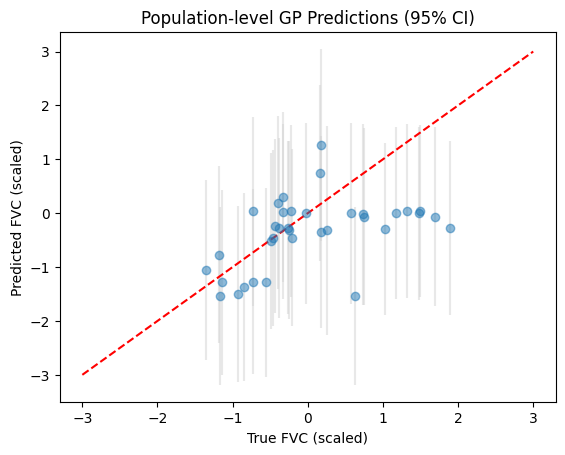

In [54]:
M1.eval()
likelihood.eval()

X_time_val = torch.as_tensor(val_df[["Weeks_scaled"]].values, dtype=torch.float32)
X_age_val  = torch.as_tensor(val_df[["Age"]].values,          dtype=torch.float32)
sex_val    = torch.as_tensor(val_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_val    = torch.as_tensor(val_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

y_true = torch.as_tensor(val_df["FVC_scaled"].values, dtype=torch.float32)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(M1(X_time_val, X_age_val, sex_val, smk_val))

y_mean = pred.mean.cpu().numpy()
y_std  = pred.variance.sqrt().cpu().numpy()
y_true = y_true.cpu().numpy()

rmse = np.sqrt(mean_squared_error(y_true, y_mean))
r2   = r2_score(y_true, y_mean)
print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")


plt.figure()
plt.errorbar(y_true, y_mean, yerr=2*y_std, fmt='o', alpha=0.5, ecolor='lightgray')
plt.plot([-3,3],[-3,3],'r--')  # 1:1 line if still scaled
plt.xlabel("True FVC (scaled)")
plt.ylabel("Predicted FVC (scaled)")
plt.title("Population-level GP Predictions (95% CI)")
plt.show()


It appears to be that the model does not capture any patterns present in the given data, which is most likely because one kernel for time offset was shared by all points across different patients, which did not allow the model to take individual patient's variance into account. To address this problem, a new kernel method is implemented:
1. Mean function is no longer the global linear mean, but a mixed-effects mean that captures patient differences
2. Covariance term now includes an additional index kernel on patient IDS which adds extra covarariance across different patients

In [28]:
X_time_train = torch.tensor(train_df[["Weeks_scaled"]].values, dtype=torch.float32)
X_age_train = torch.tensor(train_df[["Age"]].values, dtype=torch.float32)

pid_map = {k:i for i,k in enumerate(train_df["Patient"].astype("category").cat.categories)}
sex_map = {k:i for i,k in enumerate(train_df["Sex"].astype("category").cat.categories)}
smk_map = {k:i for i,k in enumerate(train_df["SmokingStatus"].astype("category").cat.categories)}
pid_train = torch.tensor(train_df["Patient"].map(pid_map).values, dtype=torch.long).unsqueeze(-1)
sex_train = torch.tensor(train_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_train = torch.tensor(train_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

sex_card = train_df["Sex"].nunique()
smk_card = train_df["SmokingStatus"].nunique()
n_patients = train_df["Patient"].nunique()

baseline_fvc = train_df.groupby('Patient')['FVC_scaled'].first().to_dict()
train_df['Baseline_FVC'] = train_df['Patient'].map(baseline_fvc)
val_df['Baseline_FVC'] = val_df['Patient'].map(baseline_fvc)
X_baseline_train = torch.tensor(train_df[["Baseline_FVC"]].values, dtype=torch.float32)

y_train = torch.tensor(train_df["FVC_scaled"].values, dtype=torch.float32)

class MixedKernel(nn.Module):
    def __init__(self, n_patients, sex_card, smk_card, emb_dim=2):
        super().__init__()
        self.beta0 = nn.Parameter(torch.zeros(1))
        self.beta_w = nn.Linear(1, 1, bias=False)  # weeks effect
        self.beta_a = nn.Linear(1, 1, bias=False)  # age effect
        self.beta_b = nn.Linear(1, 1, bias=False)  # baseline FVC effect (NEW!)

        self.alpha = nn.Embedding(n_patients, 1)
        self.gamma = nn.Embedding(n_patients, 1)

        self.sex_emb = nn.Embedding(sex_card, emb_dim)
        self.smk_emb = nn.Embedding(smk_card, emb_dim)
        self.cat_lin = nn.Linear(2*emb_dim, 1, bias=False)

    def forward(self, weeks, age, baseline_fvc, pid, sex_id, smk_id, use_patient_effects=True):
        # Population-level effects (now includes baseline FVC!)
        base = self.beta0 + self.beta_w(weeks) + self.beta_a(age) + self.beta_b(baseline_fvc)
        base = base.squeeze()
        
        # Demographic effects
        sex_emb = self.sex_emb(sex_id.squeeze(-1))
        smk_emb = self.smk_emb(smk_id.squeeze(-1))
        cat = self.cat_lin(torch.cat([sex_emb, smk_emb], dim=-1))
        cat = cat.squeeze()
        
        # Patient-specific effects
        if use_patient_effects and pid is not None:
            alpha = self.alpha(pid.squeeze(-1)).squeeze()
            gamma = self.gamma(pid.squeeze(-1)).squeeze()
            weeks_1d = weeks.squeeze()
            pat = alpha + gamma * weeks_1d
            return base + pat + cat
        else:
            return base + cat

    
class GPM2(gpytorch.models.ExactGP):
    def __init__(self, weeks, age, baseline_fvc, pid, sex, smk, y, likelihood, 
                 n_patients, sex_card, smk_card, emb_dim=2):
        # Add baseline_fvc to training inputs
        super().__init__((weeks, age, baseline_fvc, sex, smk), y, likelihood)
        
        self.mean_module = MixedKernel(n_patients, sex_card, smk_card, emb_dim=emb_dim)
        self.time_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=1)
        )
        self.emb_dim = emb_dim
        self.n_patients = n_patients
        self.register_buffer('train_pid', pid.squeeze(-1))

    def forward(self, weeks, age, baseline_fvc, sex_id, smk_id, pid=None, use_patient_effects=True):
        if pid is None and self.training:
            pid = self.train_pid.unsqueeze(-1)
        
        mean_x = self.mean_module(weeks, age, baseline_fvc, pid, sex_id, smk_id, use_patient_effects)
        covar = self.time_kernel(weeks)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar)
    

likelihood = GaussianLikelihood()
M2 = GPM2(X_time_train, X_age_train, X_baseline_train, pid_train, sex_train, smk_train, 
          y_train, likelihood, n_patients, sex_card, smk_card, emb_dim=2)

M2.train()
likelihood.train()
optimizer = torch.optim.Adam(M2.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, M2)

for i in range(200):  
    optimizer.zero_grad()
    weeks, age, baseline_fvc, sex, smk = M2.train_inputs  # Now 5 inputs
    output = M2(weeks, age, baseline_fvc, sex, smk, use_patient_effects=True)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 20 == 0:
        print(f"Iter {i+1}/200 - Loss: {loss.item():.3f}")


Iter 20/200 - Loss: 1.976
Iter 40/200 - Loss: 1.140
Iter 60/200 - Loss: 1.032
Iter 80/200 - Loss: 0.964
Iter 100/200 - Loss: 0.890
Iter 120/200 - Loss: 0.805
Iter 140/200 - Loss: 0.709
Iter 160/200 - Loss: 0.597
Iter 180/200 - Loss: 0.460
Iter 200/200 - Loss: 0.307


Input checks:
X_time_val has NaN: False
X_age_val has NaN: False
X_baseline_val has NaN: True
sex_val has NaN: False
smk_val has NaN: False
MAE: nan
RMSE: nan


c:\Users\rlaal\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_axes.py:7101: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\rlaal\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_axes.py:7102: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "_zmq.py", line 169, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


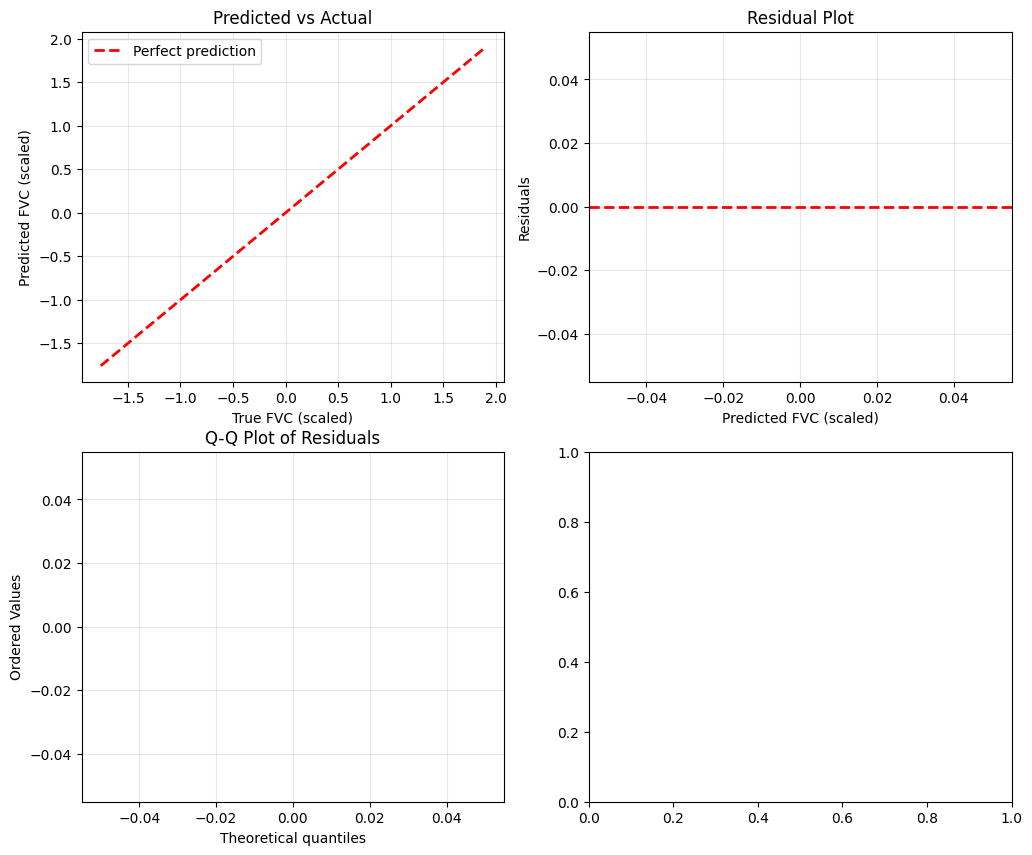

In [ ]:
M2.eval()
likelihood.eval()

X_time_val = torch.tensor(val_df[["Weeks_scaled"]].values, dtype=torch.float32)
X_age_val = torch.tensor(val_df[["Age"]].values, dtype=torch.float32)
baseline_fvc_val = val_df.groupby('Patient')['FVC_scaled'].first().to_dict()
val_df['Baseline_FVC'] = val_df['Patient'].map(baseline_fvc_val)
sex_val = torch.tensor(val_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_val = torch.tensor(val_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

print("Input checks:")
print(f"X_time_val has NaN: {torch.isnan(X_time_val).any()}")
print(f"X_age_val has NaN: {torch.isnan(X_age_val).any()}")
print(f"X_baseline_val has NaN: {torch.isnan(X_baseline_val).any()}")  # <-- Most likely culprit
print(f"sex_val has NaN: {torch.isnan(sex_val.float()).any()}")
print(f"smk_val has NaN: {torch.isnan(smk_val.float()).any()}")

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(M2(X_time_val, X_age_val, X_baseline_val, sex_val, smk_val, 
                         use_patient_effects=False))
    y_pred = pred.mean.numpy()
    y_std = pred.variance.sqrt().numpy()

y_true = val_df["FVC_scaled"].values
residuals = y_true - y_pred

mae = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals**2))
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Predicted vs Actual
axes[0, 0].scatter(y_true, y_pred, alpha=0.5, s=20)
axes[0, 0].plot([y_true.min(), y_true.max()], 
                [y_true.min(), y_true.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('True FVC (scaled)')
axes[0, 0].set_ylabel('Predicted FVC (scaled)')
axes[0, 0].set_title('Predicted vs Actual')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual Plot
axes[0, 1].scatter(y_pred, residuals, alpha=0.5, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted FVC (scaled)')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot (for residual normality)
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Residuals')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residual Histogram
axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Residual Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nResidual Statistics:")
print(f"Mean: {residuals.mean():.4f}")
print(f"Std: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")

print(f"R squared: {r2_score(y_true, y_pred)}")
